**This notebook shows how to run inference with MIPHEI-vit on a H&E image**.

**Nuclei segmentation masks are generated using CellPose on the H&E image.**. Please note, that we can also use more recent Nuclei segmentation model, like HoverNet, CellViT etc. These masks are used to extract **single-cell predictions** by computing the **mean predicted mIF expression** within each cell. A **logistic regression model**, trained on the ORION training set, is then applied to classify cell types.

![Inference Pipeline](inference_pipeline.png)
**Figure:** Inference pipeline used for cell type prediction.

**Use this notebook to run inference on your own images**.

# Import Packages

In [1]:
import pyvips
from omegaconf import OmegaConf
from cellpose import models
import json
import albumentations as A
from pathlib import Path
import torch
from safetensors.torch import load_file
import numpy as np
from timm.layers import resample_abs_pos_embed
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
from src.dataset import get_effective_width_height
from src.generators import get_generator
from src.utils import MeanCellExtrator

def validate_load_info(load_info):
    """
    Validates the result of model.load_state_dict(..., strict=False).

    Raises:
        ValueError if unexpected keys are found,
        or if missing keys are not related to the allowed encoder modules.
    """
    # 1. Raise if any unexpected keys
    if load_info.unexpected_keys:
        raise ValueError(f"Unexpected keys in state_dict: {load_info.unexpected_keys}")

    # 2. Raise if any missing keys are not part of allowed encoder modules
    for key in load_info.missing_keys:
        if ".lora" in key:
            raise ValueError(f"Missing LoRA checkpoint in state_dict: {key}")
        elif not any(part in key for part in ["encoder.vit.", "encoder.model."]):
            raise ValueError(f"Missing key in state_dict: {key}")


/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.morphology import binary_dilation, disk

def inference_cellpose(x, cellpose_model, radius=None):
    nuclei_mask, _, _, _ = cellpose_model.eval(
            x,
            channels=[0, 0],
            diameter=None,
            min_size=15,
            normalize=True,
            invert=True,
            flow_threshold=0.4,
    )

    if radius is not None:
        # watershed nuclei expansion
        binary = nuclei_mask > 0
        dilated_mask = binary_dilation(binary, footprint=disk(radius))
        distance = ndi.distance_transform_edt(~binary)
        nuclei_mask = watershed(-distance, markers=nuclei_mask, mask=dilated_mask, watershed_line=False)
    return nuclei_mask


def inference_cellpose_batch(x, cellpose_model, radius=None):
    nuclei_mask, _, _, _ = cellpose_model.eval(
                list(x),
                channels=[0, 0],
                diameter=None,
                min_size=15,
                normalize=True,
                invert=True,
                flow_threshold=0.4,
        )

    if radius is not None:
        for i in range(len(nuclei_mask)):
            binary = nuclei_mask[i] > 0
            dilated_mask = binary_dilation(binary, footprint=disk(radius))
            distance = ndi.distance_transform_edt(~binary)
            nuclei_mask[i] = watershed(-distance, markers=nuclei_mask[i], mask=dilated_mask, watershed_line=False)

    nuclei_mask = np.stack(nuclei_mask, axis=0)
    return nuclei_mask


def create_nuclei_types(nuclei_mask_torch, cell_predictions, cell_ids):
    height, width = nuclei_mask_torch.shape[2], nuclei_mask_torch.shape[3]
    nuclei_types_torch = torch.zeros((1, 15, height, width), dtype=torch.bool)

    for idx_class in range(15):
        cell_ids_class = cell_ids[cell_predictions[..., idx_class]]
        nuclei_types_torch[:, idx_class] = torch.isin(nuclei_mask_torch, cell_ids_class).cpu()
    return nuclei_types_torch

# ROI Inference

In [3]:
checkpoint_dir = "/root/workdir/checkpoints_paper/vitmatte_hotpimus_lora" # select the checkpoint directory
MPP = 0.5  # Set to None if you don't know the mpp of the input images. Best is 0.5 mpp
IMAGE_PATH = "../figures/tile_orion_he.png"

In [ ]:
checkpoint_path = str(Path(checkpoint_dir) / "model.safetensors")
config_path = str(Path(checkpoint_dir) / "config.yaml")

cfg = OmegaConf.load(config_path)


with open(Path("..") / cfg.data.channel_stats_path, "r") as f:
        channel_stats = json.load(f)

nc_out = len(cfg.data.targ_channel_names)
nc_in = 3
default_width = default_height = 256
print("Default {} width / {} height".format(default_width, default_height))
print("{} inputs channels / {} output channels".format(nc_in, nc_out))


channel_names = cfg.data.targ_channel_names
targ_channel_idxs = [channel_stats[channel_name]["idx_channel"] \
                        for channel_name in channel_names]

Default 256 width / 256 height
3 inputs channels / 16 output channels


In [5]:
torch.cuda.empty_cache()

cellpose_model = models.Cellpose(model_type="nuclei", gpu=True)
mean_extractor = MeanCellExtrator().cuda()
n_marker = nc_out - 1
logreg = torch.nn.Linear(15, n_marker)
logreg_state_dict = torch.load(str(Path(checkpoint_path).parent / "logreg.pth"), map_location="cpu")
logreg.load_state_dict(logreg_state_dict)
logreg.eval().cuda()

generator = get_generator(cfg.model.model_name, default_width, nc_in, nc_out, cfg)
state_dict = load_file(checkpoint_path, device="cpu")

load_info = generator.load_state_dict(state_dict, strict=False)
validate_load_info(load_info)
generator = generator.eval().cuda().half()

In [6]:
radius = 1 / MPP if MPP is not None else None  # used for nuclei expansion to approximate cells from nuclei

In [7]:
from PIL import Image

image_pil = Image.open(IMAGE_PATH)
width, height = image_pil.size
width, height = get_effective_width_height(width, height, train=True) # avoid non **2 dimensions, use CentralCrop is necessary

mean = (0.828, 0.764, 0.839)
std = (0.118, 0.143, 0.104)
center_crop = A.CenterCrop(width=width, height=height)
transforms = A.Compose([
    A.Normalize(mean=mean, std=std),
    A.pytorch.transforms.ToTensorV2()
], additional_targets={"image_target": "image", "nuclei": "image"})

generator.set_input_size((width, height))

We run the inference for the image using CellPose for nuclei identificaiton, and a logistic regression model for cell type classification. The code below shows how to run the inference on a single image.

Please note, that we can use more recent Nuclei segmentation model, like HoverNet, CellViT etc. The classifier is also a simple logistic regression model, but we can also use more complex models, like XGBoost, MLP etc.

In [8]:
image = np.asarray(image_pil)
image = center_crop(image=image)["image"]
x = transforms(image=image)["image"]

nuclei_mask = inference_cellpose(image, cellpose_model, radius=radius)
nuclei_mask_torch = torch.from_numpy(nuclei_mask).unsqueeze(0).unsqueeze(0).cuda().long()

with torch.inference_mode():
    pred = generator(x.unsqueeze(0).half().cuda())
    pred = pred.clamp(-0.9, 0.9)
    pred_cell_means, _, cell_ids = mean_extractor(pred.float(), None, nuclei_mask_torch)
    pred_cell_means = (pred_cell_means + 0.9) / 1.8 * 255
    cell_predictions = torch.sigmoid(logreg(pred_cell_means[..., 1:])) > 0.5
    nuclei_types_torch = create_nuclei_types(nuclei_mask_torch, cell_predictions, cell_ids).cpu()
    cell_ids = cell_ids.cpu()
    pred = (pred + 0.9) / 1.8
    pred = (pred * 255).to(torch.uint8).cpu()

pred = pred[0].numpy()
cell_ids = cell_ids.numpy()
nuclei_types_torch = nuclei_types_torch[0].numpy() # binary cell mask with shape (n_cell_type, x width, height)

Text(0.5, 1.0, 'H&E image with Cellpose nuclei mask')

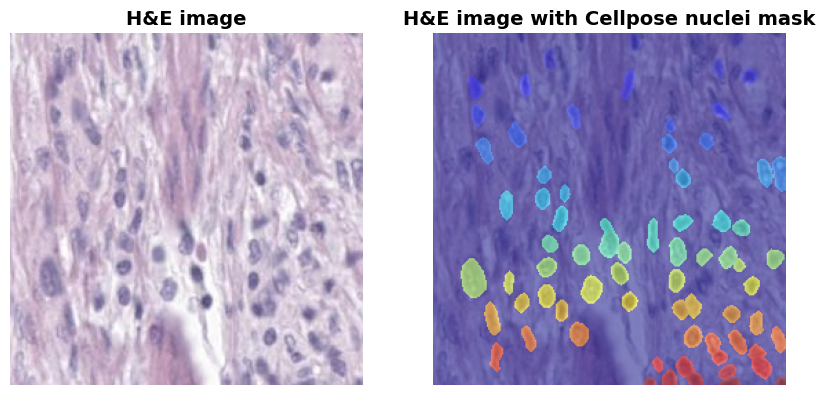

In [10]:
fig, axis = plt.subplots(1, 2, figsize=(10, 10))
axis[0].imshow(image)
axis[0].axis("off")
axis[0].set_title("H&E image", fontsize=14, fontweight="bold")

axis[1].imshow(image)
axis[1].imshow(nuclei_mask, alpha=0.5, cmap="jet")
axis[1].axis("off")
axis[1].set_title("H&E image with Cellpose nuclei mask", fontsize=14, fontweight="bold")

/tmp/ipykernel_4912/1659621353.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


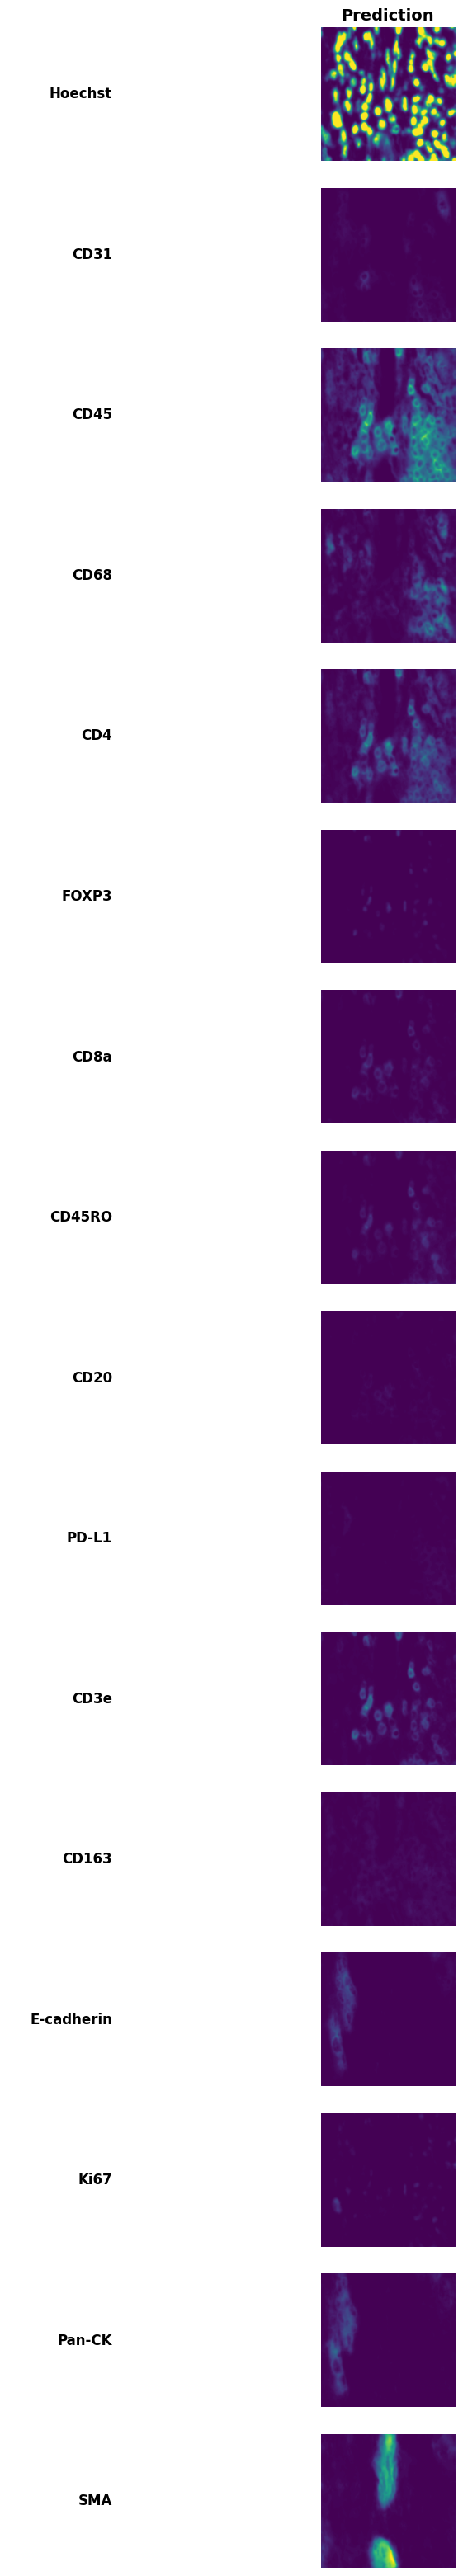

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

n_channels = len(channel_names)
fig = plt.figure(figsize=(10, 2.5 * n_channels))
gs = gridspec.GridSpec(n_channels, 2, width_ratios=[0.2, 1], wspace=0.05)

for i in range(n_channels):
    # Label column
    ax_label = fig.add_subplot(gs[i, 0])
    ax_label.axis("off")
    ax_label.text(1.0, 0.5, channel_names[i],
                  va='center', ha='right', fontsize=12, fontweight='bold')

    # Prediction
    ax_pred = fig.add_subplot(gs[i, 1])
    ax_pred.imshow(pred[i], vmin=0, vmax=100, cmap='viridis')
    ax_pred.axis("off")
    if i == 0:
        ax_pred.set_title("Prediction", fontsize=14, fontweight="bold")


plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Predicted CD45RO+ cells')

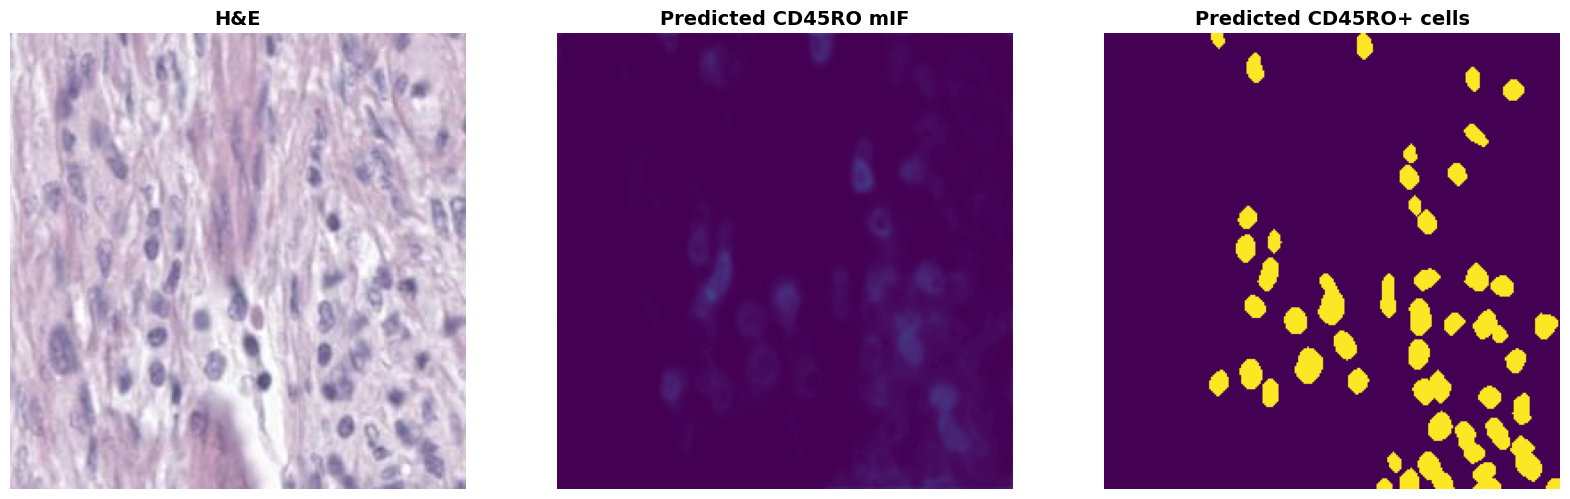

In [12]:
channel_name_vis = "CD45RO"

idx_channel = cfg.data.targ_channel_names.index(channel_name_vis) - 1


fig, axis = plt.subplots(1, 3, figsize=(20, 20))
axis[0].imshow(image)
axis[0].axis("off")
axis[0].set_title("H&E", fontsize=14, fontweight="bold")

axis[1].imshow(pred[idx_channel + 1], vmin=0, vmax=100)
axis[1].axis("off")
axis[1].set_title(f"Predicted {channel_name_vis} mIF", fontsize=14, fontweight="bold")

axis[2].imshow(nuclei_types_torch[idx_channel])
axis[2].axis("off")
axis[2].set_title(f"Predicted {channel_name_vis}+ cells", fontsize=14, fontweight="bold")

## Inference using SlideVips

In [13]:
from slidevips import SlideVips
from slidevips.tiling import get_locs_otsu

MPP_TARGET = 0.5
SLIDE_PATH = "/root/workdir/Immucan/HandE_registered/IMMU-CRC1-0131-FIXT-02-HES-02_#_160dc5ac6fa4738fcd080b1f7f83eb2f.ome.tiff"

slide_he = SlideVips(SLIDE_PATH)
slide_he.resize(slide_he.mpp / MPP_TARGET)

thumbnail = slide_he.get_thumbnail((3000, 3000))
tile_positions, _ = get_locs_otsu(thumbnail, slide_he.dimensions, 1024)

generator.set_input_size((1024, 1024))

mean = (0.828, 0.764, 0.839)
std = (0.118, 0.143, 0.104)
transforms = A.Compose([
    A.CenterCrop(width=1024, height=1024),
    A.Normalize(mean=mean, std=std),
    A.pytorch.transforms.ToTensorV2()
], additional_targets={"image_target": "image", "nuclei": "image"})

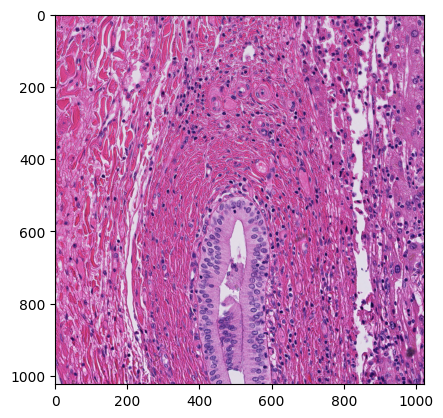

In [23]:
tile_position = tile_positions[np.random.randint(len(tile_positions))]

tile = slide_he.read_region(tile_position, 0, (1024, 1024))
plt.imshow(tile)

In [24]:
x = transforms(image=tile)["image"]

nuclei_mask = inference_cellpose(tile, cellpose_model, radius=radius)
nuclei_mask_torch = torch.from_numpy(nuclei_mask).unsqueeze(0).unsqueeze(0).cuda().long()

with torch.inference_mode():
    pred = generator(x.unsqueeze(0).half().cuda())
    pred = pred.clamp(-0.9, 0.9)
    pred_cell_means, _, cell_ids = mean_extractor(pred.float(), None, nuclei_mask_torch)
    pred_cell_means = (pred_cell_means + 0.9) / 1.8 * 255
    cell_predictions = torch.sigmoid(logreg(pred_cell_means[..., 1:])) > 0.5
    nuclei_types_torch = create_nuclei_types(nuclei_mask_torch, cell_predictions, cell_ids).cpu()
    cell_ids = cell_ids.cpu()
    pred = (pred + 0.9) / 1.8
    pred = (pred * 255).to(torch.uint8).cpu()

pred = pred[0].numpy()
cell_ids = cell_ids.numpy()
nuclei_types_torch = nuclei_types_torch[0].numpy()

Text(0.5, 1.0, 'H&E image with Cellpose nuclei mask')

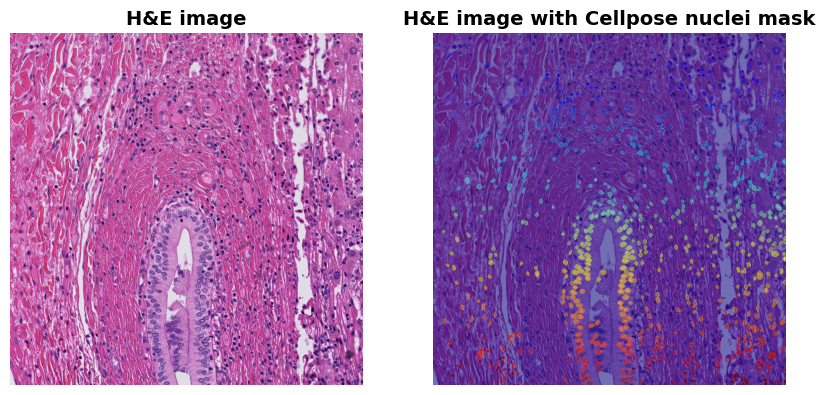

In [25]:
fig, axis = plt.subplots(1, 2, figsize=(10, 10))
axis[0].imshow(tile)
axis[0].axis("off")
axis[0].set_title("H&E image", fontsize=14, fontweight="bold")

axis[1].imshow(tile)
axis[1].imshow(nuclei_mask, alpha=0.5, cmap="jet")
axis[1].axis("off")
axis[1].set_title("H&E image with Cellpose nuclei mask", fontsize=14, fontweight="bold")

/tmp/ipykernel_4912/1659621353.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


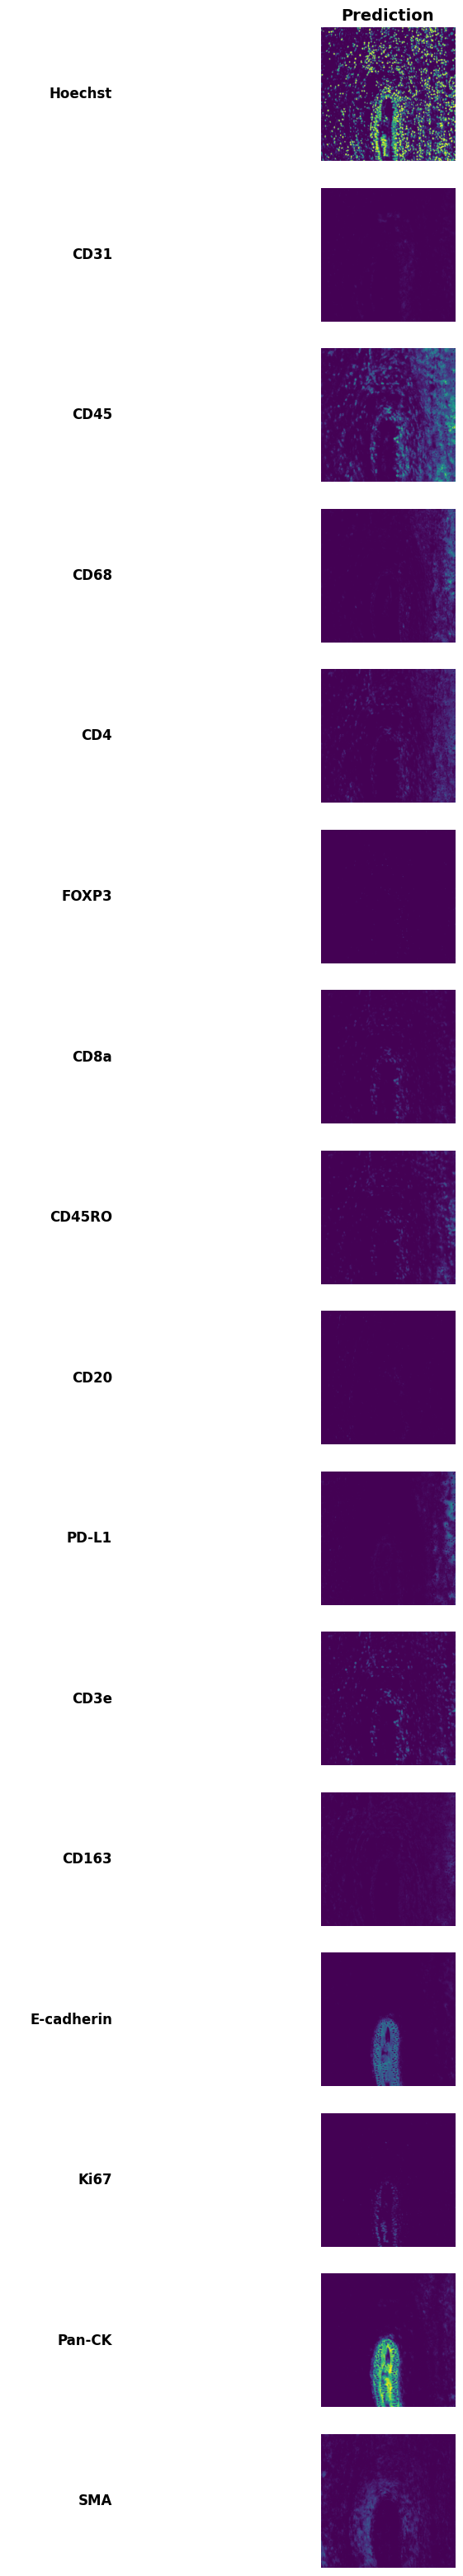

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

n_channels = len(channel_names)
fig = plt.figure(figsize=(10, 2.5 * n_channels))
gs = gridspec.GridSpec(n_channels, 2, width_ratios=[0.2, 1], wspace=0.05)

for i in range(n_channels):
    # Label column
    ax_label = fig.add_subplot(gs[i, 0])
    ax_label.axis("off")
    ax_label.text(1.0, 0.5, channel_names[i],
                  va='center', ha='right', fontsize=12, fontweight='bold')

    # Prediction
    ax_pred = fig.add_subplot(gs[i, 1])
    ax_pred.imshow(pred[i], vmin=0, vmax=100, cmap='viridis')
    ax_pred.axis("off")
    if i == 0:
        ax_pred.set_title("Prediction", fontsize=14, fontweight="bold")


plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Predicted Pan-CK+ cells')

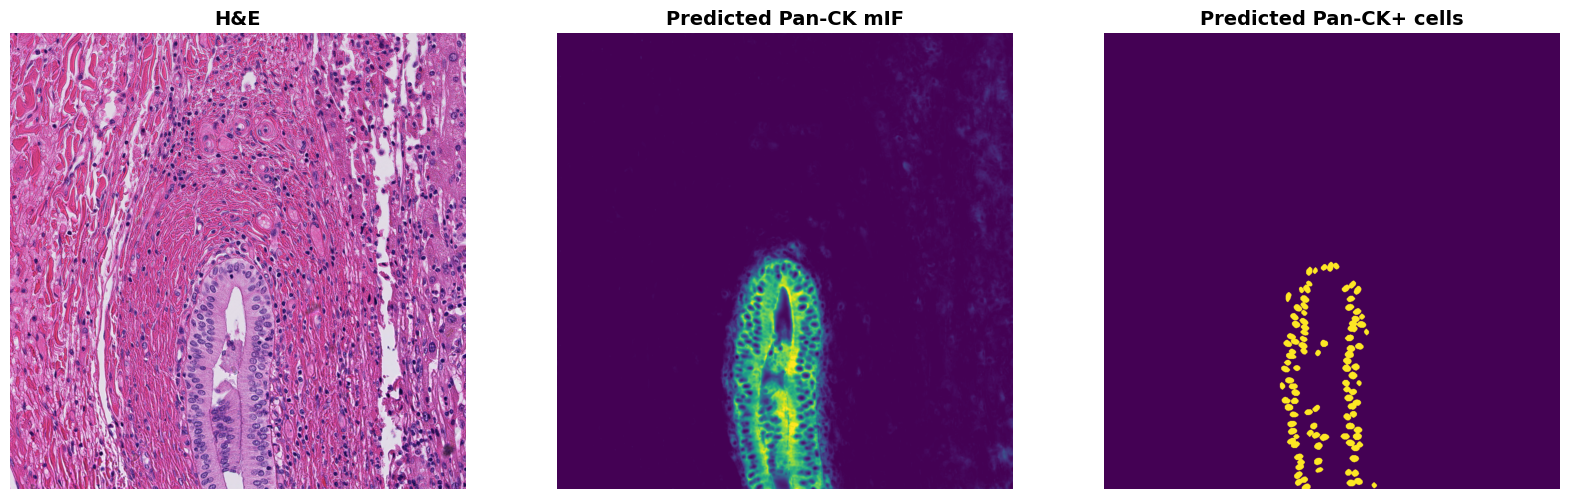

In [27]:
channel_name_vis = "Pan-CK"

idx_channel = cfg.data.targ_channel_names.index(channel_name_vis) - 1


fig, axis = plt.subplots(1, 3, figsize=(20, 20))
axis[0].imshow(tile)
axis[0].axis("off")
axis[0].set_title("H&E", fontsize=14, fontweight="bold")

axis[1].imshow(pred[idx_channel + 1], vmin=0, vmax=100)
axis[1].axis("off")
axis[1].set_title(f"Predicted {channel_name_vis} mIF", fontsize=14, fontweight="bold")

axis[2].imshow(nuclei_types_torch[idx_channel])
axis[2].axis("off")
axis[2].set_title(f"Predicted {channel_name_vis}+ cells", fontsize=14, fontweight="bold")

In [ ]:
from src.generators.foundation_models import FOUNDATION_MODEL_REGISTRY
from src.generators.lora import apply_lora
from src.generators.mipheivit import Detail_Capture, ViTMatte, Backbone
import torch.nn as nn



num_classes = 3
ckpt_path = "/root/workdir/foundation_models/univ2.bin"
img_size = 256

use_lora = True

vit = FOUNDATION_MODEL_REGISTRY["univ2"](
    img_size, ckpt_path=ckpt_path, drop_path_rate=0, global_pool="")

if use_lora:
    apply_lora(vit, rank=8, alpha=1.)
decoder = Detail_Capture(emb_chans=vit.embed_dim, out_chans=num_classes, use_attention=True, activation=nn.Tanh())
model = ViTMatte(encoder=Backbone(vit), decoder=decoder)
model.eval().cuda().half()

In [51]:
with torch.no_grad():
    out = model(torch.rand(size=(1, 3, img_size, img_size)).cuda().half())

In [52]:
out.shape

torch.Size([1, 3, 256, 256])